In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# load dataset
file_path = '/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = pd.read_csv(file_path)


# Object Setting
**Introduction to the Project Background**

Employees are the backbone of companies and organizations, and the performance of companies and organizations is greatly influenced by the quality of employees.

When the number of such employees decreases, the company faces the following problems.
  - Time and cost required to select and train new employees
  - Loss of skilled employee
  - Reduced productivity
  - Decrease in profits

So, companies should strive to reduce employee attrition.

Employee attrition may occur due to several reasons as follows.
  - Seek better opportunities
  - Negative work environment
  - Poor employee management
  - Employee health issues
  - Excessive working hours

Therefore, it is important to analyze what factors affect employee attrition because it can provide suggestions on what efforts a company should make to avoid problems caused by employee attrition.

**Project Goal**

Our goal is to provide companies with useful information to avoid the negative effects of employee attrition by analyzing big data, such as identifying what factors affect employee attrition and creating a model to predict whether an employee will leave the company. Ultimately, this will help reduce employee attrition within the company.

# Elbow method

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_k):
    """
    Determines the optimal number of clusters for KMeans clustering using the Elbow Method and Silhouette Score.

    Parameters
    ----------
    data : array-like of shape (n_samples, n_features)
        The input data to be clustered.
    max_k : int
        The maximum number of clusters to consider.

    Returns
    -------
    int
        The optimal number of clusters based on the silhouette score.

    Examples
    --------
    >>> from sklearn.datasets import make_blobs
    >>> data, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
    >>> optimal_k = find_optimal_clusters(data, 10)
    The optimal number of clusters based on silhouette score is: 4
    """
    
    # Define the range of k to iterate over, increasing by 2 each step from 2 to max_k.
    iters = range(2, max_k + 1, 2)

    # Initialize lists to store SSE (Sum of Squared Errors) and silhouette scores.
    sse = []
    silhouettes = []

    for k in iters:
        # Initialize KMeans with k clusters.
        kmeans = KMeans(n_clusters=k, random_state=42)
        # Fit KMeans to the data.
        kmeans.fit(data)
        # Append the SSE to the list.
        sse.append(kmeans.inertia_)
        # Calculate the silhouette score for the clustering.
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        # Append the silhouette score to the list.
        silhouettes.append(silhouette_avg)

    # Create subplots to visualize SSE and silhouette scores.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot SSE versus number of clusters.
    ax1.plot(iters, sse, marker='o')
    ax1.set_xlabel('Number of cluster centers')
    ax1.set_ylabel('SSE')
    ax1.set_title('Elbow Method for Optimal k')

    # Plot silhouette scores versus number of clusters.
    ax2.plot(iters, silhouettes, marker='o')
    ax2.set_xlabel('Number of cluster centers')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score for Optimal k')

    plt.show()

    # Find the index of the maximum silhouette score and the corresponding optimal k value.
    optimal_k = iters[silhouettes.index(max(silhouettes))]
    print(f'The optimal number of clusters based on silhouette score is: {optimal_k}')
    return optimal_k

# Preprocessing and hiperparams tuning

In [3]:
def masterFunc(df_pca, df_km):
    """
    Performs hyperparameter optimization and evaluates different machine learning models with various preprocessing techniques.

    Parameters
    ----------
    df_pca : pandas.DataFrame
        The dataframe with PCA-transformed features.
    df_km : pandas.DataFrame
        The dataframe with KMeans-transformed features.

    Returns
    -------
    pandas.DataFrame
        A dataframe containing the top 5 model configurations sorted by F1 score.

    Examples
    --------
    >>> df_pca = pd.read_csv('data_pca.csv')
    >>> df_km = pd.read_csv('data_km.csv')
    >>> top_5_models = masterFunc(df_pca, df_km)
    """
    
    X_pca = df_pca.drop('Attrition', axis=1)
    X_km = df_km.drop('Attrition', axis=1)
    y_pca = df_pca['Attrition']
    y_km = df_km['Attrition']

    models = {
        "Logistic Regression": {
            "model": LogisticRegression(random_state=11),
            "params": {
                "C": [0.1, 1, 10],
                "penalty": ['l1', 'l2'],
                "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                "max_iter": [1000, 2000, 3000]
            }
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(random_state=11),
            "params": {
                "criterion": ['gini', 'entropy'],
                "max_depth": [1, 5, 10],
                "min_samples_split": [2, 10, 20],
                "min_samples_leaf": [1, 5, 10],
                "max_features": [None, 'sqrt', 'log2']
            }
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=11),
            "params": {
                "n_estimators": [10, 50, 100],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": list(range(1, 11)),
                "min_child_weight": list(range(1, 11)),
                "subsample": [0.5, 0.7, 1.0],
                "colsample_bytree": [0.5, 0.7, 1.0],
                "gamma": [0, 0.1, 0.2]
            }
        },
    }

    results = []

    scalers = {
        "Min Max": MinMaxScaler(),
        "Standard": StandardScaler(),
        "Robust": RobustScaler()
    }

    encoders = {
        "One Hot": OneHotEncoder(sparse_output=False),
        "Label": LabelEncoder()
    }

    datasets = {
        "PCA": (X_pca, y_pca),
        "KMeans": (X_km, y_km)
    }

    for model_name, model_info in models.items():
        for scaler_name, scaler in scalers.items():
            for encoder_name, encoder in encoders.items():
                for data_name, (data, y) in datasets.items():
                    X_encoded = data.copy()
                    if encoder_name == "Label":
                        # Apply Label Encoding for categorical features
                        for col in data.select_dtypes(include=['object']).columns.tolist():
                            X_encoded[col] = encoder.fit_transform(X_encoded[col])
                        X_transformed = scaler.fit_transform(X_encoded)
                    else:
                        # Apply One-Hot Encoding for categorical features
                        numeric_data = data.select_dtypes(include=[np.number])
                        categorical_data = data.select_dtypes(include=['object'])
                        encoded_categorical_data = encoder.fit_transform(categorical_data)
                        X_transformed = scaler.fit_transform(numeric_data)
                        X_transformed = np.hstack((X_transformed, encoded_categorical_data))
                    
                    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

                    # SMOTE
                    smote = SMOTE(random_state=42)
                    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

                    model = model_info["model"]

                    # Randomized Search
                    random_search = RandomizedSearchCV(
                        model,
                        param_distributions=model_info["params"],
                        scoring='f1',
                        n_iter=10,
                        n_jobs=-1,
                        cv=5,
                        random_state=42
                    )
                    
                    random_search.fit(X_resampled, y_resampled)

                    best_model = random_search.best_estimator_
                    y_pred = best_model.predict(X_test)
                    
                    scores = {
                        'recall': recall_score(y_test, y_pred),
                        'precision': precision_score(y_test, y_pred),
                        'f1': f1_score(y_test, y_pred),
                        'accuracy': accuracy_score(y_test, y_pred)
                    }

                    results.append({
                        "accuracy": scores['accuracy'],
                        "f1": scores['f1'],
                        "model": model_name,
                        "params": random_search.best_params_,
                        "scaler_name": scaler_name,
                        "encoder_name": encoder_name,
                        "feature_reduction_method": data_name,
                        **scores
                    })

    results_df = pd.DataFrame(results)
    top_5 = results_df.sort_values(by="f1", ascending=False).head(5)
    return top_5

# Feature Reduction

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

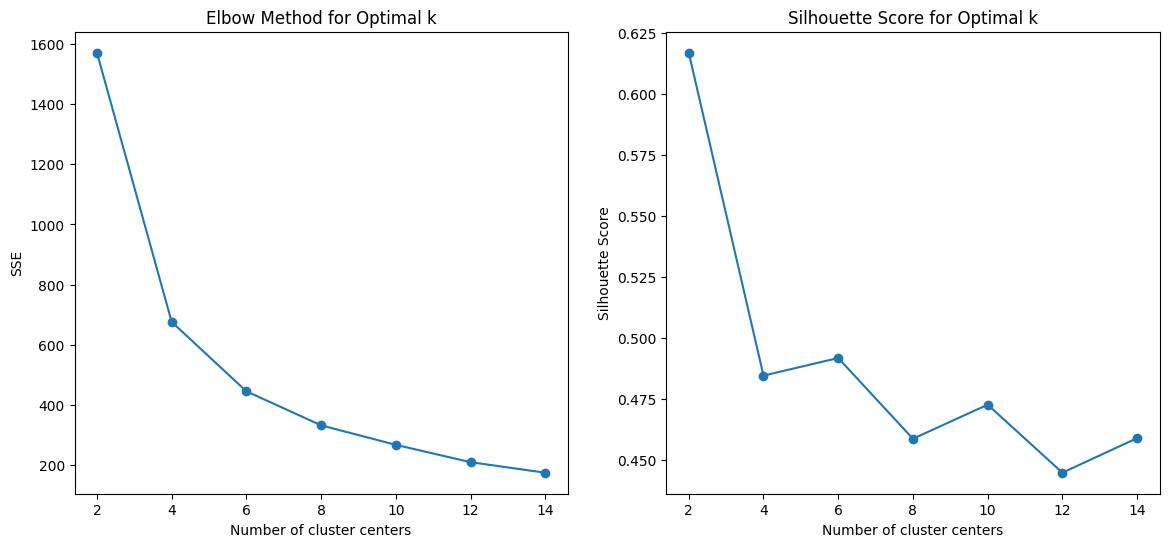

The optimal number of clusters based on silhouette score is: 2


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

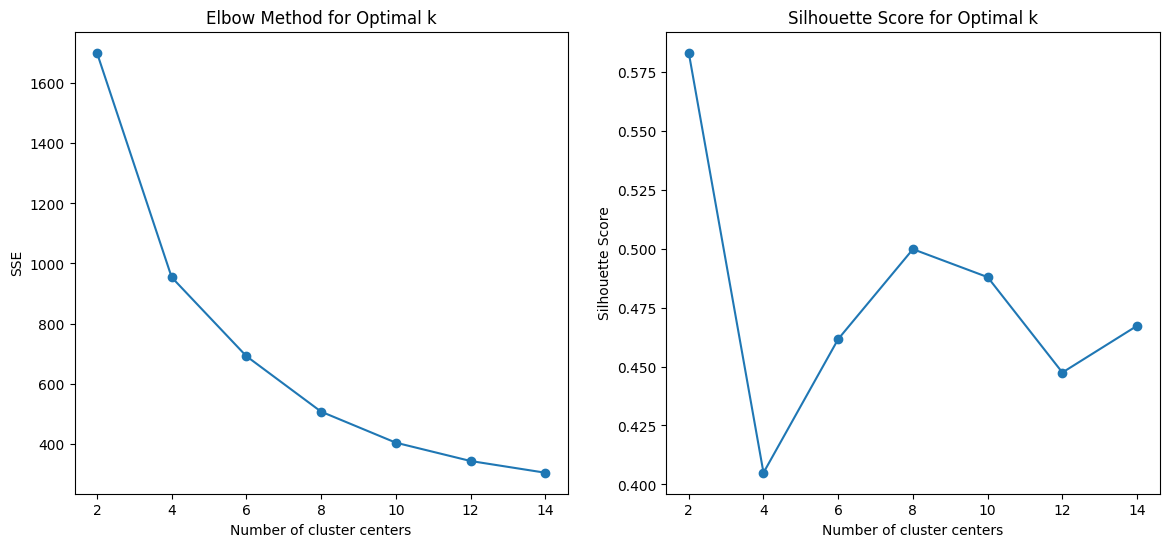

The optimal number of clusters based on silhouette score is: 2


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
# Split the dataset into features (X) and target (y)
X = df.drop('Attrition', axis=1)
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Define groups of highly correlated features
high_corr_groups = [
    {'MonthlyIncome', 'JobLevel', 'TotalWorkingYears'},
    {'YearsWithCurrManager', 'YearsInCurrentRole', 'YearsAtCompany'}
]

# Create copies of the original features for PCA and KMeans transformations
pca_data = X.copy()
kmeans_data = X.copy()

for i, group in enumerate(high_corr_groups):
    group_data = X[list(group)]
    scaler = StandardScaler()
    # Standardize the features
    standardized_features = pd.DataFrame(scaler.fit_transform(group_data), columns=group_data.columns)

    # Apply PCA to the standardized features
    pca = PCA(n_components=min(len(group), 0.95))
    principal_components = pca.fit_transform(standardized_features)
    principal_df = pd.DataFrame(principal_components, columns=[f'pca_{i+1}_{j+1}' for j in range(principal_components.shape[1])], index=group_data.index)

    # Concatenate PCA components to the original data
    pca_data = pd.concat([pca_data, principal_df], axis=1)

    # Determine the optimal number of clusters for KMeans
    optimal_k = find_optimal_clusters(standardized_features, 15)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(standardized_features)
    # Add KMeans cluster labels to the data
    kmeans_data[f'KMeans_{i+1}'] = kmeans.labels_

    # Drop the original highly correlated features from the KMeans data
    kmeans_data = kmeans_data.drop(columns=list(group))

# Save the transformed datasets to CSV files
pca_data.to_csv('pca_data.csv', index=False)
kmeans_data.to_csv('kmeans_data.csv', index=False)

# Split the PCA transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_data, y, test_size=0.2, random_state=42, stratify=y)

# Prepare cleaned PCA data for validation
train_df_cleaned_pca = X_train_pca.copy()
train_df_cleaned_pca['Attrition'] = y_train_pca

# Prepare cleaned PCA data for evaluation
test_df_cleaned_pca = X_test_pca.copy()
test_df_cleaned_pca['Attrition'] = y_test_pca

# Split the KMeans transformed data into training and testing sets
X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(kmeans_data, y, test_size=0.2, random_state=42, stratify=y)

# Prepare cleaned KMeans data for validation
train_df_cleaned_km = X_train_km.copy()
train_df_cleaned_km['Attrition'] = y_train_km

# Prepare cleaned KMeans data for evaluation
test_df_cleaned_km = X_test_km.copy()
test_df_cleaned_km['Attrition'] = y_test_km

# Find Best 5 Model

In [5]:
# run masterFunc
top_combinations = masterFunc(train_df_cleaned_pca,train_df_cleaned_km)
print(top_combinations)

#result
top_combinations_result_file = 'top_combinations_result2.csv'
top_combinations.to_csv(top_combinations_result_file, index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

    accuracy        f1    model  \
26  0.872881  0.615385  XGBoost   
30  0.868644  0.586667  XGBoost   
32  0.860169  0.571429  XGBoost   
24  0.851695  0.545455  XGBoost   
34  0.860169  0.535211  XGBoost   

                                               params scaler_name  \
26  {'subsample': 0.7, 'n_estimators': 100, 'min_c...     Min Max   
30  {'subsample': 0.5, 'n_estimators': 50, 'min_ch...    Standard   
32  {'subsample': 0.7, 'n_estimators': 100, 'min_c...      Robust   
24  {'subsample': 0.7, 'n_estimators': 100, 'min_c...     Min Max   
34  {'subsample': 1.0, 'n_estimators': 50, 'min_ch...      Robust   

   encoder_name feature_reduction_method    recall  precision  
26        Label                      PCA  0.545455   0.705882  
30        Label                      PCA  0.500000   0.709677  
32      One Hot                      PCA  0.500000   0.666667  
24      One Hot                      PCA  0.477273   0.636364  
34        Label                      PCA  0.431818   0

# Evaluation

accuracy                                                             0.872881
f1                                                                   0.615385
model                                                                 XGBoost
params                      {'subsample': 0.7, 'n_estimators': 100, 'min_c...
scaler_name                                                           Min Max
encoder_name                                                            Label
feature_reduction_method                                                  PCA
recall                                                               0.545455
precision                                                            0.705882
Name: 0, dtype: object
{'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.7}
Accuracy: 0.9729
Precision: 1.0000
Recall: 0.8743
F1 Score: 0.9232


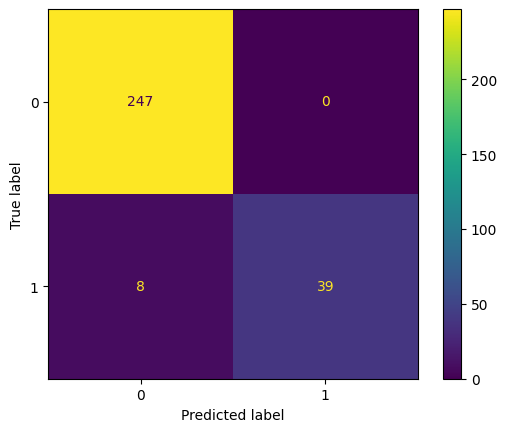

In [6]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_validate, cross_val_predict
# Load the optimal model and parameters
top_combinations = pd.read_csv('top_combinations_result2.csv')
best_combination = top_combinations.iloc[0]
print(best_combination)
best_model_name = best_combination['model']
best_model_params = eval(best_combination['params'])
print(best_model_params)
best_scaler_name = best_combination['scaler_name']
best_encoder_name = best_combination['encoder_name']
best_transform_name = best_combination['feature_reduction_method']

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define scalers
scalers = {
    "Min Max": MinMaxScaler(),
    "Standard": StandardScaler(),
    "Robust": RobustScaler()
}

# Define encoders
encoders = {
    "One Hot": OneHotEncoder(sparse_output=False),
    "Label": LabelEncoder()
}

# Apply the best scaler and encoder
scaler = scalers[best_scaler_name]
encoder = encoders[best_encoder_name]

# Select the appropriate feature-reduced dataset
df_cleaned_fr = test_df_cleaned_pca
y_test = y_test_pca
if best_transform_name == 'KMeans':
    df_cleaned_fr = test_df_cleaned_km
    y_test = y_test_km

# Encode and scale the data
if best_encoder_name == "Label":
    X_encoded = df_cleaned_fr.copy()
    for col in df_cleaned_fr.select_dtypes(include=['object']).columns.tolist():
        X_encoded[col] = encoder.fit_transform(X_encoded[col])
    X_transformed = scaler.fit_transform(X_encoded)
else:
    numeric_data = df_cleaned_fr.select_dtypes(include=[np.number])
    categorical_data = df_cleaned_fr.select_dtypes(include=['object'])
    encoded_categorical_data = encoder.fit_transform(categorical_data)
    X_transformed = scaler.fit_transform(numeric_data)
    X_transformed = np.hstack((X_transformed, encoded_categorical_data))

# Apply the best model with optimal parameters
model = models[best_model_name]
model.set_params(**best_model_params)

# Evaluate the model performance using cross-validation
kf = KFold(n_splits=5, shuffle=True,random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, ),
    'recall': make_scorer(recall_score, ),
    'f1': make_scorer(f1_score, )
}

# Use cross_validate to compute multiple metrics
cv_results = cross_validate(model, X_transformed, y_test, cv=kf, scoring=scoring)
y_pred = cross_val_predict(model, X_transformed, y_test, cv=kf)

# Print evaluation results
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"F1 Score: {np.mean(cv_results['test_f1']):.4f}")

# Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()